# Import libraries

In [823]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
import seaborn as sns
from prophet import Prophet
import scipy.stats as stats
from scipy.stats import shapiro, anderson, normaltest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# EDA

In [93]:
raw_data = pd.read_csv('CupIT_Sber_data.csv', sep=';', decimal=',')
raw_data.head()

,service_document_id,account_document_id,service_date,service_amount_net,patient_id,service_code,service_name,is_hospital
0,0xE3A4BED668151E271B6680FE5E8772D6,0xFDD38318ED6FC6EC68131DB6671F100C,2022-01-01 12:07:00.0000000,1925.0,0xD2B5A46F0FFF14D5209ED49B6215BDA0,0xCDEA5658E0AD52E1700653CAE2A4928D,0x95758EBA87326C4D5DECC8B51A8B9C61,0
1,0xD1DD45B19A9195143BE217BD83702901,0x9F7486A2D5FEFFF7453777B1D0592E16,2022-01-01 12:17:00.0000000,4800.0,0x0A1FF218569A9829DDA53CBDF9FD12F9,0x1ECB5F528158D6C0BC98B017169D3E5B,0x48137991AF094338080AC09C4A51E050,0
2,0xAB000FD6D4A66E6E1523907DEBFEC85D,0x72CBB210256CBF07F48DCACFDA4A3E4C,2022-01-01 12:30:00.0000000,1710.0,0xECA1B4580DFE64AC35678C0EC46CFB56,0x727B72BA7EB94341537D4FA18BAF9D7C,0x9F45909133FB97131C44DD00094F781E,0
3,0x53A548619940E6DF7D910D17905D1CFD,0x34082776539FC71066087BA9EB78986D,2022-01-01 12:33:00.0000000,2040.0,0xF3F9B8D552B3F35BD9F4E553E1C84AA8,0x5AF4EDF46C78DFB3049268F4C9708407,0xC311E151328A1118224B8A3F163AD3C0,0
4,0x1FDDAF54CB064A6E27519F2B6DF97B0E,0x5809EF65F6969882A139F7A484B8D95C,2022-01-01 12:27:00.0000000,2200.0,0xF599395DBD681B9A446C26F2DB9E0BF2,0xE6EEC1C29E25C790C0088B42F82CBA55,0x95758EBA87326C4D5DECC8B51A8B9C61,0


Посмотрим на тип данных каждого атрибута, если потребуется переопределим их в нужные форматы

In [16]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091043 entries, 0 to 1091042
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   service_document_id  1091043 non-null  object 
 1   account_document_id  1091043 non-null  object 
 2   service_date         1091043 non-null  object 
 3   service_amount_net   1091043 non-null  float64
 4   patient_id           1091043 non-null  object 
 5   service_code         1091043 non-null  object 
 6   service_name         1091043 non-null  object 
 7   is_hospital          1091043 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 66.6+ MB


Первое знакомство с данымми говорит нам о том, что пропущенных значений нет, у полей service_amount_net и is_hospital правильно считался формат данных.
Поле service_date необходимо преобразовать в datetime, остальные поля такие как service_code, service_name и подобные привести к категориям.
Поменяем тип данных service_date и соберем небольшую статистику.

In [94]:
raw_data['service_date'] = pd.to_datetime(raw_data['service_date'], yearfirst=True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091043 entries, 0 to 1091042
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   service_document_id  1091043 non-null  object        
 1   account_document_id  1091043 non-null  object        
 2   service_date         1091043 non-null  datetime64[ns]
 3   service_amount_net   1091043 non-null  float64       
 4   patient_id           1091043 non-null  object        
 5   service_code         1091043 non-null  object        
 6   service_name         1091043 non-null  object        
 7   is_hospital          1091043 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 66.6+ MB


In [20]:
raw_data.describe()

,service_date,service_amount_net,is_hospital
count,1091043,1.091043e+06,1.091043e+06
mean,2023-01-10 23:05:27.043575296,2.335262e+03,9.259488e-02
min,2022-01-01 12:07:00,-2.525600e+05,0.000000e+00
25%,2022-07-14 11:04:00,4.200000e+02,0.000000e+00
50%,2023-01-16 20:02:00,1.304000e+03,0.000000e+00
75%,2023-07-11 08:59:00,2.480000e+03,0.000000e+00
max,2023-12-31 18:48:00,1.328586e+06,1.000000e+00
std,NaN,6.482097e+03,2.898640e-01


Обратим внимание, что минимальная выплата по страховке явлется отрицательной, по описанию задачи это "сторнировка", стоит посмотреть на такие записи. То есть сначала по одному документу (service_document_id) может быть выполнена выплата, а следом возврат (возможно неправильная сумма) или просто возврат, как корректировка, без последующей выплаты.

Максимальная же выплата составила 1.3 млн рублей, отчасти это может быть правдой, но стоит также проверить это.

In [96]:
raw_data.loc[raw_data['service_amount_net'] < 0].sort_values(by='service_amount_net')

,service_document_id,account_document_id,service_date,service_amount_net,patient_id,service_code,service_name,is_hospital
647605,0xF86E5F558D370BABF2C9E15101A9348F,0x9A64C3C4241BEA1316CC93A40ED00468,2023-03-20 12:23:24,-252560.00,0x7D94A359561090239FE01A3DF066DDFB,0x0F501483E6323C629718F114E5491ECD,0x5741D77C8BAE5B3106A74F7F9E85EBC4,0
1024471,0x896BA0427B543B14D2F8AB920C0B3FA3,0x139D922DF67582AB05634BA7E255A8BD,2023-11-21 14:13:11,-155834.00,0x2F2203903C1ECA97E7D248EEE3DDE3B5,0xDE388F773B8279BCC11F05FADDBE15D1,0x754097ACC3CEF36BAD6D4260F0C0357B,1
900893,0x8958B43CC7517A3DEB0DA02432FB9FBF,0x85BE534C3277B12C4020CE48DF484195,2023-09-05 14:55:09,-101430.00,0xF43DF3E2D97251830380238008AE429D,0xCC3EFE31215AAC0952519ED07BB38BBB,0xD237C780A1FEF56E9D109A41A0229A6F,0
616484,0x5B658959715CE6D0108062E652E72698,0xA8122C976F7162440E3D7F384CBF70C7,2023-03-02 11:18:11,-87295.00,0xE30AD035CFA4BB0D9C0467CC4A56DF9B,0xF00F1F39075B51FDB018353EB48C467D,0xAB8574981BF01808E15343545DAD9237,1
597372,0xE1D90685449FE24F4818031C82B8D9FA,0x194A8D16D89C92DA8D99066AFD7D2119,2023-02-17 09:47:43,-81568.00,0xA87DF4FBB2E9D41AB5D970F22860E8AD,0x3B0C7D2A624320CBC4359EA05E13FC91,0x6B3FDE110D56ED97A50DAFCD7F05EB20,1
...,...,...,...,...,...,...,...,...
293194,0x6DCA515DF17047129999B43C5DB340C7,0x462BDC2FB02BBB84FB869A66BB39EDD3,2022-07-28 11:06:21,-2.28,0xDB56296D86A6B657BCBB84827B44E80C,0x2E3501D14A7717F3DAB1781E96626B33,0xEE5A618E6313C102E1E6F04836AF907C,0
293555,0x8958C9201BE0C100ED1FC6EB0E048832,0xB3B11F0D3C83FF9D9C9F208B4F480A64,2022-07-28 11:06:23,-2.28,0xB0C4966A00BBDCD29B5C3A59B3891B79,0x2E3501D14A7717F3DAB1781E96626B33,0xEE5A618E6313C102E1E6F04836AF907C,0
291964,0xB29DF459C3BCC8961133E24DD9B2BD22,0x155F4AC6E93B3F768F8B5A58B8005C70,2022-07-28 11:06:13,-2.28,0xC563B3CD53DB3A1C1861CF3BD381DA7D,0x2E3501D14A7717F3DAB1781E96626B33,0xEE5A618E6313C102E1E6F04836AF907C,0
293098,0x5D1FEABC0E856DFD877DE9DBB4E6801D,0xF68455AE9ED732958300CBAB2D1570A0,2022-07-28 11:06:20,-2.28,0x75C7AC8A19EA28BC7AE8F9C9BC2163D2,0x2E3501D14A7717F3DAB1781E96626B33,0xEE5A618E6313C102E1E6F04836AF907C,0


In [461]:
raw_data.loc[raw_data['service_document_id'] == '0xF86E5F558D370BABF2C9E15101A9348F'].sort_values(by='service_date')

,service_document_id,account_document_id,service_date,service_amount_net,patient_id,service_code,service_name,is_hospital
571901,0xF86E5F558D370BABF2C9E15101A9348F,0x1ADB795698DBF2954C0FCE54942793EC,2023-02-01 14:19:00,252560.0,0x7D94A359561090239FE01A3DF066DDFB,0x0F501483E6323C629718F114E5491ECD,0x5741D77C8BAE5B3106A74F7F9E85EBC4,0
647605,0xF86E5F558D370BABF2C9E15101A9348F,0x9A64C3C4241BEA1316CC93A40ED00468,2023-03-20 12:23:24,-252560.0,0x7D94A359561090239FE01A3DF066DDFB,0x0F501483E6323C629718F114E5491ECD,0x5741D77C8BAE5B3106A74F7F9E85EBC4,0


В целом гипотеза о том, что это возврат оказалась верной. Необходимо будет учесть это при подготовке данных, например, выячислять дельту по service_document_id и приравнивать ее к первоначальной дате service_date.

Соберем некоторую статистику по услуге сторнировки:

In [572]:
print(f"Кол-во записей с услугой стонировки/возврата: {raw_data.loc[raw_data['service_amount_net'] < 0].shape[0]}")

print(f"Кол-во уникальных service_document_id связанных с сторнировкой: {len(raw_data['service_document_id'].loc[raw_data['service_amount_net'] < 0].unique())}")

print(f"Кол-во уникальных service_document_id связанных с сторнировкой (2022): {len(raw_data['service_document_id'].loc[(raw_data['service_amount_net'] < 0) & (raw_data['service_date'].dt.year == 2022)].unique())}")
print(f"Кол-во уникальных service_document_id связанных с сторнировкой (2023): {len(raw_data['service_document_id'].loc[(raw_data['service_amount_net'] < 0) & (raw_data['service_date'].dt.year == 2023)].unique())}")

print(f"Общая сумма по стонировке за все время: {round(raw_data['service_amount_net'].loc[raw_data['service_amount_net'] < 0].sum(),2)}\n"
      f"Сумма по стонировке за 2022: {round(raw_data['service_amount_net'].loc[(raw_data['service_amount_net'] < 0) & (raw_data['service_date'].dt.year == 2022)].sum(),2)}\n"
      f"Сумма по стонировке за 2023: {round(raw_data['service_amount_net'].loc[(raw_data['service_amount_net'] < 0) & (raw_data['service_date'].dt.year == 2023)].sum(),2)}")

print(f"Средняя сумма сторнировки: {round(raw_data['service_amount_net'].loc[raw_data['service_amount_net'] < 0].mean(),2)};"
      f" медиана суммы сторнировки: {round(raw_data['service_amount_net'].loc[raw_data['service_amount_net'] < 0].median(),2)}")

Кол-во записей с услугой стонировки/возврата: 7412
Кол-во уникальных service_document_id связанных с сторнировкой: 7388
Кол-во уникальных service_document_id связанных с сторнировкой (2022): 7113
Кол-во уникальных service_document_id связанных с сторнировкой (2023): 275
Общая сумма по стонировке за все время: -7589070.12
Сумма по стонировке за 2022: -6439183.32
Сумма по стонировке за 2023: -1149886.8
Средняя сумма сторнировки: -1023.89; медиана суммы сторнировки: -86.69


Посмотрим на другую статистику:

In [370]:
print(f"Уникальных идентификаторов документа с фиксацией факта оказания услуги: {raw_data['service_document_id'].nunique()}\n"
      f"Уникальных документов-счетов: {raw_data['account_document_id'].nunique()}\n"
      f"Уникальных мед.карт: {raw_data['patient_id'].nunique()}\n"
      f"Уникальных кодов оказанных услуг: {raw_data['service_code'].nunique()}\n"
      f"Уникальных наименования оказанных услуг: {raw_data['service_name'].nunique()}\n"
      f"Количество услуг с amount_net = 1: {raw_data[raw_data['service_amount_net'] == 1]['service_document_id'].nunique()}\n" 
      f"Количество услуг чекап (amount_net = 0): {raw_data[raw_data['service_amount_net'] == 0]['service_document_id'].nunique()}")

Уникальных идентификаторов документа с фиксацией факта оказания услуги: 1084033
Уникальных документов-счетов: 1091043
Уникальных мед.карт: 29701
Уникальных кодов оказанных услуг: 5232
Уникальных наименования оказанных услуг: 3027
Количество услуг с amount_net = 1: 1
Количество услуг чекап (amount_net = 0): 4492


Обратим внимание на график выплат и сторнировок по годам

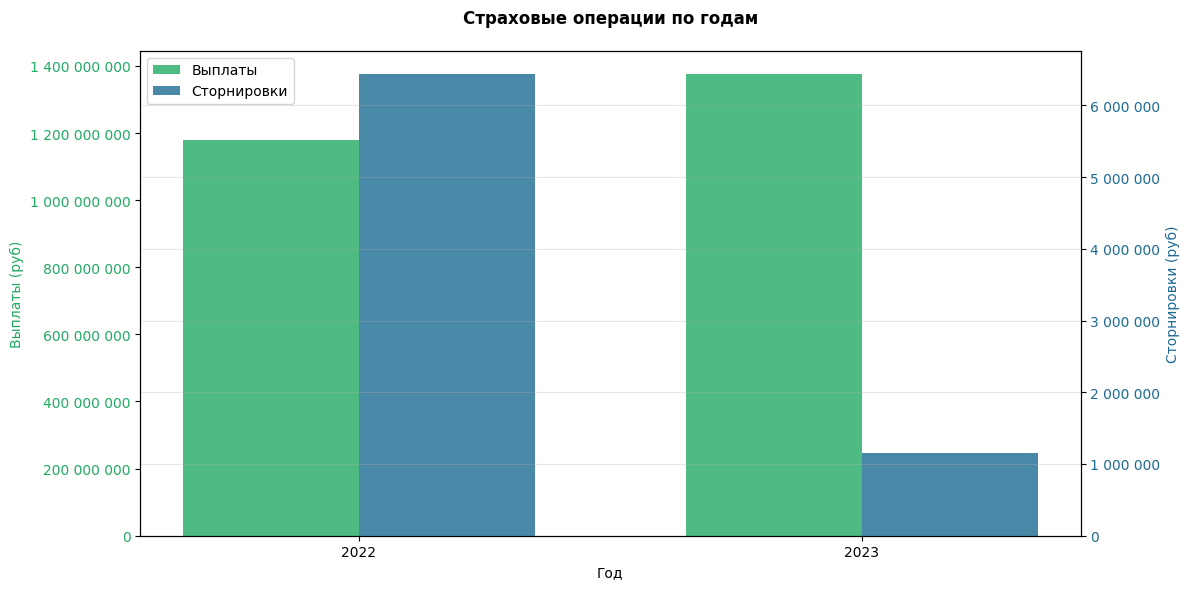

In [245]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
years = [2022, 2023]
colors = {'Выплаты': '#21AA63', 'Сторнировки': '#1D6B93'}
bar_width = 0.35

# Основная ось для выплат
ax1 = plt.gca()
ax1.set_ylabel('Выплаты (руб)', color=colors['Выплаты'])
ax1.tick_params(axis='y', labelcolor=colors['Выплаты'])

# Вторая ось для сторнировок
ax2 = ax1.twinx()
ax2.set_ylabel('Сторнировки (руб)', color=colors['Сторнировки'])
ax2.tick_params(axis='y', labelcolor=colors['Сторнировки'])

for i, year in enumerate(years):
    year_data = raw_data[raw_data['service_date'].dt.year == year]
    
    # Вычисление сумм
    pay = year_data.loc[year_data['service_amount_net'] > 0, 'service_amount_net'].sum()
    refund = abs(year_data.loc[year_data['service_amount_net'] < 0, 'service_amount_net'].sum())
    
    # Столбцы выплат на основной оси
    ax1.bar(i - bar_width/2, pay, width=bar_width, 
            color=colors['Выплаты'], alpha=0.8, 
            label='Выплаты' if i==0 else "")
    
    # Столбцы сторнировок на дополнительной оси
    ax2.bar(i + bar_width/2, refund, width=bar_width, 
            color=colors['Сторнировки'], alpha=0.8,
            label='Сторнировки' if i==0 else "")

# Настройки общей части
plt.title('Страховые операции по годам', fontweight='bold', pad=20)
plt.xticks(range(len(years)), [str(y) for y in years])
ax1.set_xlabel('Год')

# Форматирование числовых подписей
ax1.get_yaxis().set_major_formatter(lambda x, _: f"{x:,.0f}".replace(',', ' '))
ax2.get_yaxis().set_major_formatter(lambda x, _: f"{x:,.0f}".replace(',', ' '))

# Объединение легенд
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

В 2023 году выплат больше чем в 2022, обратная ситуация с сторнировкой. Посмотрим теперь по месяцам:

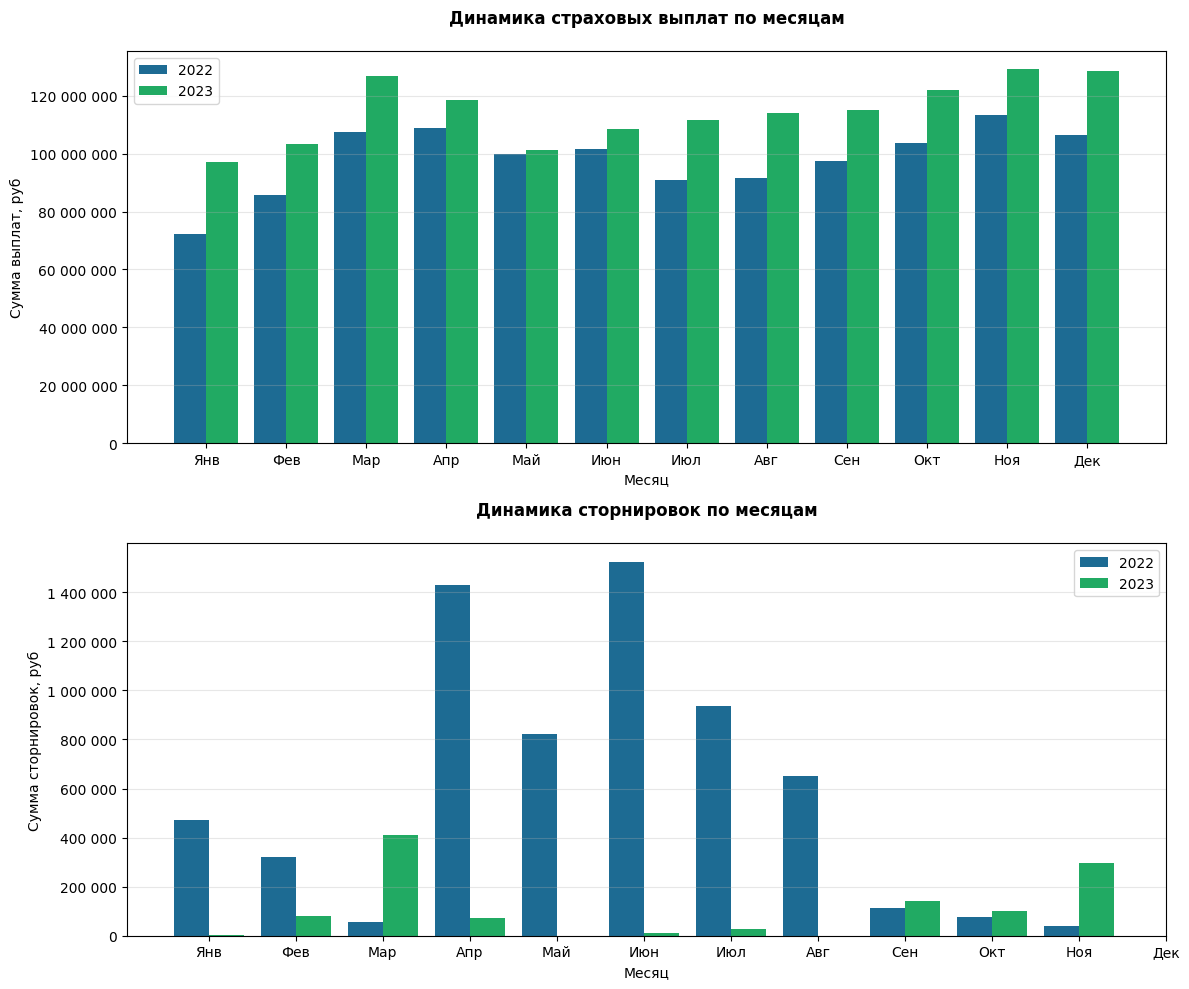

In [377]:
# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Цветовая схема
colors = {'2022': '#1D6B93', '2023': '#21AA63'}  # Синий и зеленый Сбера

# 1. График страховых выплат (положительные значения)
for year in [2022, 2023]:
    # Фильтруем данные по году и положительным выплатам
    mask = (raw_data['service_date'].dt.year == year) & (raw_data['service_amount_net'] > 0)
    year_data = raw_data.loc[mask]
    
    # Группируем по месяцам и суммируем
    monthly = year_data.groupby(year_data['service_date'].dt.month)['service_amount_net'].sum()
    
    # Строим график
    ax1.bar(monthly.index + (0.2 if year == 2023 else -0.2), 
            monthly, 
            width=0.4, 
            color=colors[str(year)],
            label=str(year))

# Настройки первого графика
ax1.set_title('Динамика страховых выплат по месяцам', fontweight='bold', pad=20)
ax1.set_ylabel('Сумма выплат, руб')
ax1.set_xlabel('Месяц')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
                    'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.get_yaxis().set_major_formatter(lambda x, _: f"{x:,.0f}".replace(',', ' '))

# 2. График сторнировок (отрицательные значения)
for year in [2022, 2023]:
    # Фильтруем данные по году и отрицательным выплатам
    mask = (raw_data['service_date'].dt.year == year) & (raw_data['service_amount_net'] < 0)
    year_data = raw_data.loc[mask]
    
    # Группируем по месяцам и суммируем абсолютные значения
    monthly = year_data.groupby(year_data['service_date'].dt.month)['service_amount_net'].sum().abs()
    
    # Строим график
    ax2.bar(monthly.index + (0.2 if year == 2023 else -0.2), 
            monthly, 
            width=0.4, 
            color=colors[str(year)],
            label=str(year))

# Настройки второго графика
ax2.set_title('Динамика сторнировок по месяцам', fontweight='bold', pad=20)
ax2.set_ylabel('Сумма сторнировок, руб')
ax2.set_xlabel('Месяц')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
                     'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.get_yaxis().set_major_formatter(lambda x, _: f"{x:,.0f}".replace(',', ' '))

plt.tight_layout()
plt.show()

На первом графике видно, что мы имеем тренд на растующие выплаты по страховым услугам, также визуально заметна некоторая сезонность. С операцией сторнировкой все неоднозначно, по сравнению с 2022 годом, сторнировки существенно уменьшились. Визуально явного тренда, а также сезонности не наблюдается.

Оценим насколько больше/меньше было оказанных услуг (service_document_id) г/г:

In [547]:
unique_sdi_years = raw_data.sort_values('service_date').drop_duplicates('service_document_id')
print(f"Уникальных оказанных услуг за 2022 год: {unique_sdi_years['service_document_id'].loc[unique_sdi_years['service_date'].dt.year == 2022].nunique()}\n"
      f"Уникальных оказанных услуг за 2023 год: {unique_sdi_years['service_document_id'].loc[unique_sdi_years['service_date'].dt.year == 2023].nunique()}")

Уникальных оказанных услуг за 2022 год: 523351
Уникальных оказанных услуг за 2023 год: 560682


In [549]:
print(f"Прирост в количестве оказанных услуг г/г: {round((560682/523351)*100 - 100, 2)}%")

Прирост в количестве оказанных услуг г/г: 7.13%


Возможно такой прирост по выплатам вызван увеличением оказанных услуг (на 7.13%) и уменьшенным объемом сторнировок.

Посмотрим на ящик с усами по полю service_amount_net, сгруппировав данные по дням:

Text(0.5, 1.0, 'Ящик с усами для поля service_amount_net')

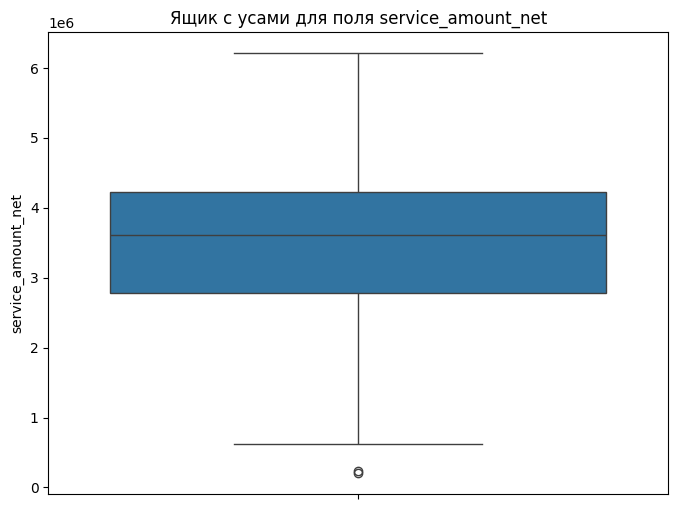

In [543]:
plt.figure(figsize=(8,6))
sns.boxplot(raw_data.groupby(raw_data['service_date'].dt.date).sum(['service_amount_net'])['service_amount_net'])
plt.title('Ящик с усами для поля service_amount_net')

Видно, что присутствуют "выбросы" ниже 25 перцентиля, в остальном выбросов по дням нет. Теперь посмотрим на распределение страховых выплат:

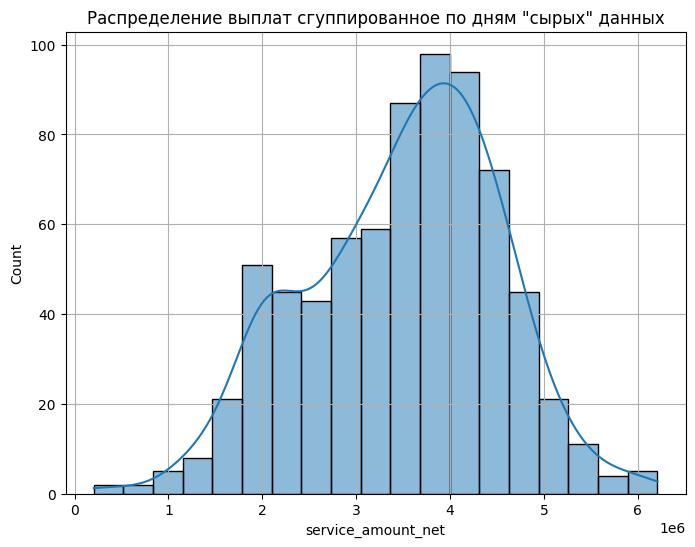

In [546]:
plt.figure(figsize=(8,6))
sns.histplot(raw_data.groupby(raw_data['service_date'].dt.date).sum(['service_amount_net'])['service_amount_net'], kde=True)
plt.title('Распределение выплат сгуппированное по дням "сырых" данных')
plt.grid()

Взглянем на суммы 10 самых больших страховых выплат

In [208]:
raw_data.nlargest(10, 'service_amount_net') 

,service_document_id,account_document_id,service_date,service_amount_net,patient_id,service_code,service_name,is_hospital
713713,0x8F559E09E5CCC0CEC413BA6997DC6C1B,0xD29BBF5ED91E9ABCAAD5E9693AC48408,2023-04-26 14:17:00,1328586.0,0xE910797DD9C83E4C9319BF69D42F3BC3,0x0B78620B11337EE1E36F66809D467E6B,0x4C15E052EB5BC8BE224DADEBB13F31F6,0
923646,0x48C009646CF40A4BA8008FB9FA534EDB,0x53B1055BA7D74EC4B2C47CEDE32D2054,2023-09-20 08:19:00,1328586.0,0xE910797DD9C83E4C9319BF69D42F3BC3,0x0B78620B11337EE1E36F66809D467E6B,0x4C15E052EB5BC8BE224DADEBB13F31F6,0
1085012,0xFB751FCE721F27AECD79EBCC91FFC8A6,0x5937457BE9F1170E1AB7206124F3C064,2023-12-26 19:01:00,1328586.0,0xE910797DD9C83E4C9319BF69D42F3BC3,0x0B78620B11337EE1E36F66809D467E6B,0x4C15E052EB5BC8BE224DADEBB13F31F6,0
452678,0xAEB2693B60E0AFE7333494F91EA3D1F5,0x219B116BCB73AE16779FC1C936009B9D,2022-11-12 19:31:00,1065240.0,0x899A3B3D0D1BFC8890B23F7017CDD7FF,0x30864507D11F3E50007A25161BEB3EFF,0xA904263742B97AA3207937AF8EF39EDA,0
452671,0x08870E30BD9E34A01003A6DAB2F52BF3,0x207D5B13F7D18260D72DAA4A33EBAB5E,2022-11-12 19:31:00,712800.0,0x899A3B3D0D1BFC8890B23F7017CDD7FF,0x55AD1975DF3DB8730DB8C4AEC7354514,0x4C15E052EB5BC8BE224DADEBB13F31F6,0
67618,0x826D1BD347DBEC3EBF0DDCE8C7C32A73,0x8C4420892C13572A78C16AE66D0EA162,2022-02-25 13:47:00,665280.0,0x3F534530EE2303C650F3EE9C2B639BC0,0x15C1F1686E2E21BD5828E212F085D1B2,0xF34E0037095421B4A492C000E42C9FCB,0
67624,0xC5AA8EC6F8394DE579AABA43FA234C48,0x5DB176A5BF1B4A94F8A46F1CAA551B56,2022-02-25 12:09:00,554256.0,0x3F534530EE2303C650F3EE9C2B639BC0,0x7766445091C3F190489FD16357A8996E,0xF60C731EF7556EE2063AB4C22FAAF311,0
311650,0x880FB0D7C65F6E02CE013E559AB82FAD,0x4CAFB1CDEDAD82145158FA2DC4714D2D,2022-08-10 15:39:00,519750.0,0xE5013371C11522C5409B813A2C436DF2,0x8AB0375E3ACD4516B54FF89B236CE336,0x45DD40279D5973542F6EDC81CCA0359A,1
255654,0x26CF725326BA780FD6EBF50D2A63D7D6,0x6405DE885695A0D88B530E26AA288809,2022-06-29 16:27:00,515000.0,0x91AACF1357EF55C8FAC529E06A19220A,0x21DB79E018B9DC084B84853674A5CECF,0x0B0C37312C24D84A168F2EE1AF6D4C1C,1
67612,0xB53E08C86AC28351C7D051812E2182B2,0x578C99ACBF4AAB786BF9775D4FDF8453,2022-02-25 12:09:00,461880.0,0x3F534530EE2303C650F3EE9C2B639BC0,0x7766445091C3F190489FD16357A8996E,0xF60C731EF7556EE2063AB4C22FAAF311,0


Создадим копию исходных данных, на которых будем далее проводить манипуляции и эксперименты.
Для анализа переодичности проведем feature engineering и создадим новые атрибуты: месяц, квартал, день, день недели. Также добавим переодичность по месяцам, а оригинальный формат даты service_date с часами, минутами и секундами заменим на простой день (yyyy-mm-dd)

Уберем из датасета записи, соотвествующие услугам чекап (service_amount_net = 0) и одну запись, где service_amount_net = 1.

## Preprocessing

In [474]:
preprocessed_data = raw_data.copy()

preprocessed_data['quarter'] = preprocessed_data['service_date'].dt.quarter
preprocessed_data['month'] = preprocessed_data['service_date'].dt.month
preprocessed_data['day'] = preprocessed_data['service_date'].dt.day
preprocessed_data['day_of_week'] = preprocessed_data['service_date'].dt.day_of_week
preprocessed_data['year_months'] = preprocessed_data['service_date'].dt.to_period('M')
preprocessed_data['service_date'] = preprocessed_data['service_date'].dt.date


preprocessed_data = preprocessed_data.loc[
    (preprocessed_data['service_amount_net'] != 0)
      & (preprocessed_data['service_amount_net'] != 1)]
preprocessed_data.shape

(1086550, 13)

In [499]:
# дельта по сторнировке 
preprocessed_data_sdi_delta = preprocessed_data.copy()
sum_sdi = preprocessed_data_sdi_delta[['service_document_id', 'service_amount_net']].groupby('service_document_id').sum('service_amount_net').sort_values('service_document_id')

preprocessed_data_sdi_delta = preprocessed_data_sdi_delta.sort_values('service_date').drop_duplicates('service_document_id', keep='first').sort_values('service_document_id')
# preprocessed_data_sdi_delta = pd.merge(preprocessed_data_sdi_delta, sum_sdi, 'inner', on='service_document_id').drop(columns=['service_amount_net_x'])
# preprocessed_data_sdi_delta.rename(columns={'service_amount_net_y': 'service_amount_net'}, inplace=True)
preprocessed_data_sdi_delta['service_amount_net'] = sum_sdi['service_amount_net'].to_list()
preprocessed_data_sdi_delta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1079611 entries, 20326 to 233088
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype    
---  ------               --------------    -----    
 0   service_document_id  1079611 non-null  object   
 1   account_document_id  1079611 non-null  object   
 2   service_date         1079611 non-null  object   
 3   service_amount_net   1079611 non-null  float64  
 4   patient_id           1079611 non-null  object   
 5   service_code         1079611 non-null  object   
 6   service_name         1079611 non-null  object   
 7   is_hospital          1079611 non-null  int64    
 8   quarter              1079611 non-null  int32    
 9   month                1079611 non-null  int32    
 10  day                  1079611 non-null  int32    
 11  day_of_week          1079611 non-null  int32    
 12  year_months          1079611 non-null  period[M]
dtypes: float64(1), int32(4), int64(1), object(6), period[M](1)
memory usage: 9

In [500]:
# избавимся от нулевых сумм
preprocessed_data_sdi_delta = preprocessed_data_sdi_delta.loc[preprocessed_data_sdi_delta['service_amount_net'] != 0]
preprocessed_data_sdi_delta.shape

(1078777, 13)

In [561]:
preprocessed_data_sdi_delta.loc[pd.to_datetime(preprocessed_data_sdi_delta['service_date']).dt.year == 2023].groupby('is_hospital')['service_amount_net'].mean()

is_hospital
0    2333.722739
1    3746.089007
Name: service_amount_net, dtype: float64

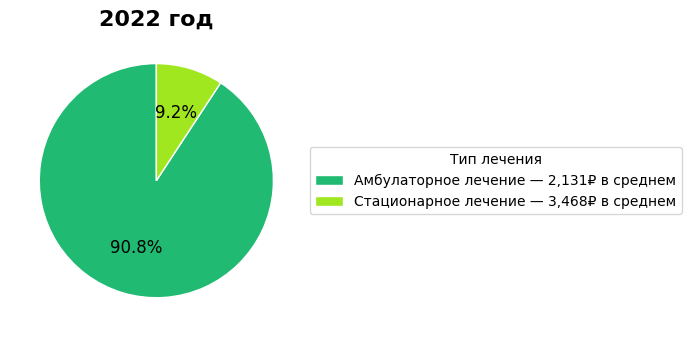

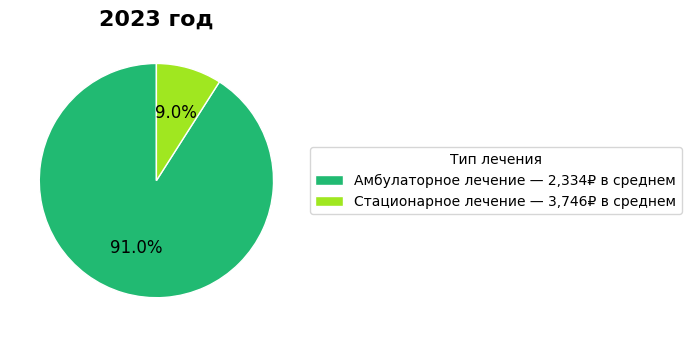

In [568]:
#график пирог по типу is_hospital

colors = ['#21BA72', '#A0E720']
labels_map = {0: 'Амбулаторное лечение', 1: 'Стационарное лечение'}

def plot_pie_for_year(data, year):
    data_year = data[pd.to_datetime(data['service_date']).dt.year == year]
    
    counts = data_year.groupby('is_hospital')['is_hospital'].count()
    means = data_year.groupby('is_hospital')['service_amount_net'].mean()

    # Сортируем по [0, 1] чтобы цвета всегда совпадали
    values = [counts.get(k, 0) for k in [0, 1]]
    mean_values = [means.get(k, 0) for k in [0, 1]]
    labels = [labels_map[k] for k in [0, 1]]
    
    # Текст для легенды
    legend_labels = [f"{label} — {mean:,.0f}₽ в среднем" for label, mean in zip(labels, mean_values)]

    # Рисуем
    fig, ax = plt.subplots(figsize=(7, 7))
    wedges, texts, autotexts = ax.pie(
        values,
        labels=None,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops=dict(edgecolor='white'),
        textprops={'fontsize': 12}
    )

    # Название
    ax.set_title(f"{year} год", fontsize=16, fontweight='bold')

    # Легенда сбоку
    ax.legend(wedges, legend_labels, title="Тип лечения", loc="center left", bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

# Построим по очереди
plot_pie_for_year(preprocessed_data_sdi_delta, 2022)
plot_pie_for_year(preprocessed_data_sdi_delta, 2023)


После предобработки данных взлягнем на распределение по выплатам

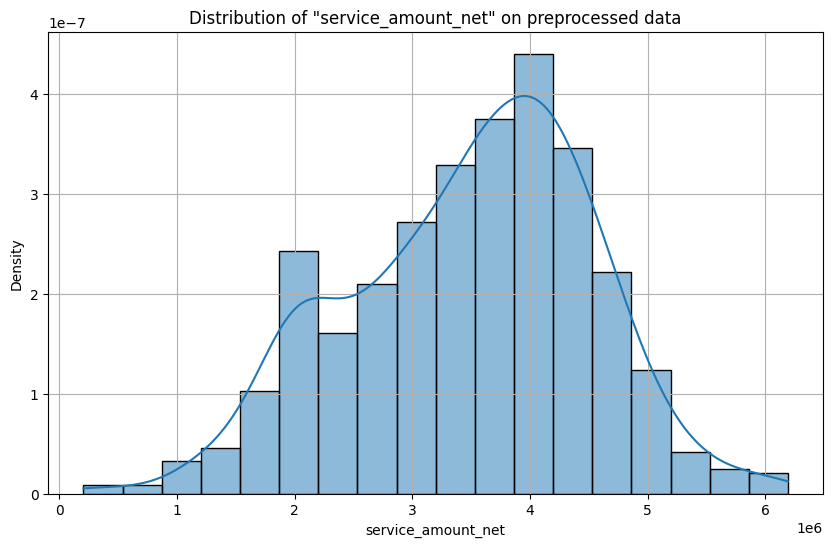

In [501]:
ts_delta = preprocessed_data_sdi_delta.groupby('service_date').sum('service_amount_net')['service_amount_net']
plt.figure(figsize=(10,6))
sns.histplot(ts_delta, bins=int(2*(len(ts_delta)**(1/3))), kde=True, stat='density') # для опр-ия количества bins воспользуемся правилом Rice (2 * pow(N, 1/3))
plt.title('Distribution of "service_amount_net" on preprocessed data')
plt.grid()

Распределение похоже на нормальное, но с небольшой асимметрией влево (левый хвост длиннее), также присутствует умеренный пик около 3.8-4.0 млн, то есть это типичная дневная выплата.
Небольшое смещение влево может свидетельствовать о наличии дней с низкой активностью (выходные, праздники). 
Обращая внимания на левый и правый хвост можно сказать, что бывает дни с низкой выплатой и с большой суммой страховки.

Чтобы подтвердить нормальность данных, проведем ряд статистических тестов, а аткже обратимся к QQ-plot, чтобы визуально также проверить нормальность (иногда тесты могут ошибаться)

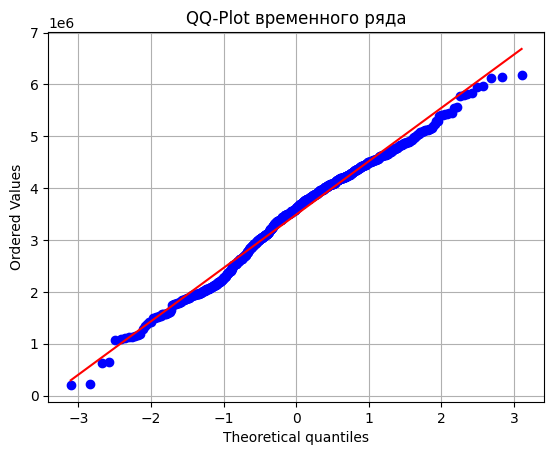

In [714]:
stats.probplot(ts_delta, dist="norm", plot=plt)
plt.title("QQ-Plot временного ряда")
plt.grid()

In [720]:
def check_normality(series, alpha=0.05):
    print("▶️ Проверка нормальности распределения\n")

    # 1. Shapiro-Wilk
    stat, p = shapiro(series)
    print("- Shapiro-Wilk Test:")
    print(f"    Статистика = {stat:.4f}, p-value = {p:.4f}")
    if p < alpha:
        print("    Отклоняем H₀ -> Ряд НЕ нормальный\n")
    else:
        print("    Не отклоняем H₀ -> Ряд нормальный\n")

    # 2. Anderson-Darling
    result = anderson(series, dist='norm')
    print("- Anderson-Darling Test:")
    print(f"    Статистика = {result.statistic:.4f} (если стат. больше крит. знач -> не нормальное распределение)")
    for sl, cv in zip(result.significance_level, result.critical_values):
        print(f"    Уровень значимости {sl:.0f}%: критическое значение = {cv:.3f}")
    print()

    # 3. D’Agostino and Pearson
    stat, p = normaltest(series)
    print("- D’Agostino and Pearson Test:")
    print(f"    Статистика = {stat:.4f}, p-value = {p:.4f}")
    if p < alpha:
        print("    Отклоняем H₀ -> Ряд НЕ нормальный\n")
    else:
        print("    Не отклоняем H₀ -> Ряд нормальный\n")

check_normality(ts_delta)

▶️ Проверка нормальности распределения

- Shapiro-Wilk Test:
    Статистика = 0.9869, p-value = 0.0000
    Отклоняем H₀ -> Ряд НЕ нормальный

- Anderson-Darling Test:
    Статистика = 3.9243 (если стат. больше крит. знач -> не нормальное распределение)
    Уровень значимости 15%: критическое значение = 0.573
    Уровень значимости 10%: критическое значение = 0.652
    Уровень значимости 5%: критическое значение = 0.783
    Уровень значимости 2%: критическое значение = 0.913
    Уровень значимости 1%: критическое значение = 1.086

- D’Agostino and Pearson Test:
    Статистика = 12.6235, p-value = 0.0018
    Отклоняем H₀ -> Ряд НЕ нормальный



Такое может быть, что тесты не подтверждают нормальность данных. Вероятно хвосты оказывают большее влияние или присутствует что-то еще. Так или иначе мы не используем напрямую статистические модели (ARIMA, линейную регрессию), поэтому в нашем случае ряд можно считать "нормальным".

Text(0.5, 1.0, 'Ящик с усами для поля service_amount_net')

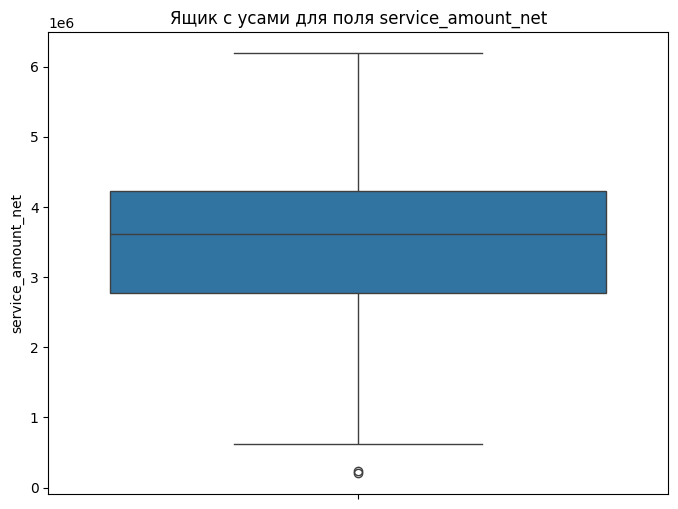

In [502]:
plt.figure(figsize=(8,6))
sns.boxplot(ts_delta)
plt.title('Ящик с усами для поля service_amount_net')

Все еще присутствуют некоторое количество выбросов, убирать их не будем, так как это может нарушить структуру ряда.

Посмотрим на временной ряд и его сглаженные средние

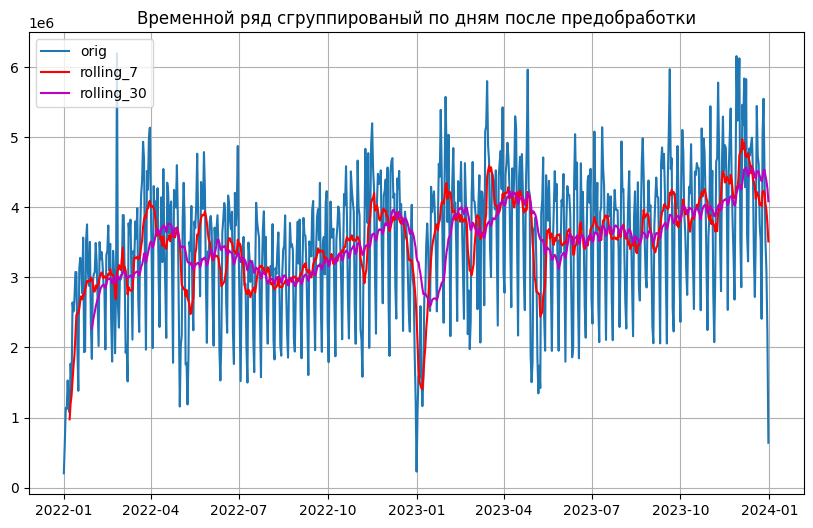

In [683]:
plt.figure(figsize=(10,6))
plt.plot(ts_delta, label='orig')
plt.plot(ts_delta.rolling(7).mean(), label='rolling_7', color='r')
plt.plot(ts_delta.rolling(30).mean(), label='rolling_30', color='m')

# plt.plot(np.log(ts_delta.rolling(7).mean()).diff(), label='rolling_7')
# plt.plot(np.log(ts_delta.rolling(30).mean()).diff(), label='rolling_30')
plt.title('Временной ряд сгруппированый по дням после предобработки')
plt.legend()
plt.grid()

На представленном графике у временного ряда визуально прослеживается несколько сезонностей: годовая, месячная/квартальная. Годовая видна по падающим выплатам в январе, месячная/квартальная видна по рисунку "седло", то есть идет просадка примерно с апреля по ноябрь.

Посмотрим на график месячных выплат:

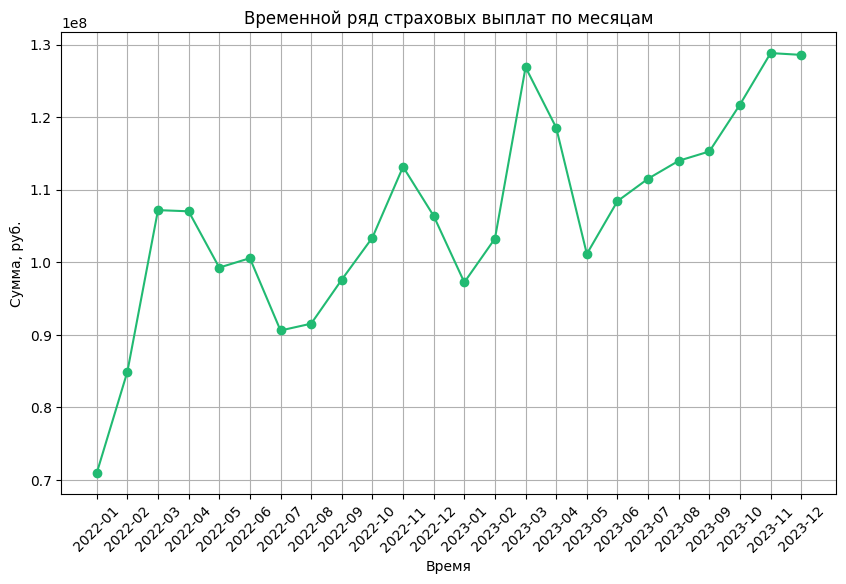

In [676]:
ts_months = preprocessed_data_sdi_delta.groupby('year_months').sum('service_amount_net').reset_index()
plt.figure(figsize=(10,6))
plt.plot(ts_months['year_months'].apply(lambda x: str(x)), ts_months['service_amount_net'], color = '#21BA72', marker='o')
plt.title('Временной ряд страховых выплат по месяцам')
plt.xticks(rotation=45)
plt.xlabel('Время')
plt.ylabel('Сумма, руб.')
plt.grid()

На данном графике также видна годовая сезонность - падение к январю и последующий рост с коррекцией к апрелю. Однако из-за сгруппированных данных по месяцам на графике не наблюдается резкое падаение в январе 2023 года, как на графике выше (ежедневных данных), вероятно в январе 2023 были большие выпаты, что способствовало повышению на помесячном графике.

Проведем статистический тест ADF на стационарность ряда:

In [717]:
print(f"ADF Statistic: {adfuller(ts_delta.dropna())[0]}")
print(f"p-value: {adfuller(ts_delta.dropna())[1]}")

if adfuller(ts_delta.dropna())[1] < 0.05:
    print("Ряд стационарен (отвергаем H₀)")
else:
    print("Ряд нестационарен (не отвергаем H₀)")


ADF Statistic: -3.569688935910463
p-value: 0.006367662547060937
Ряд стационарен (отвергаем H₀)


# Определение сезонности, автокорреляции и прочее

### Автокорреляция для ежедневных данных

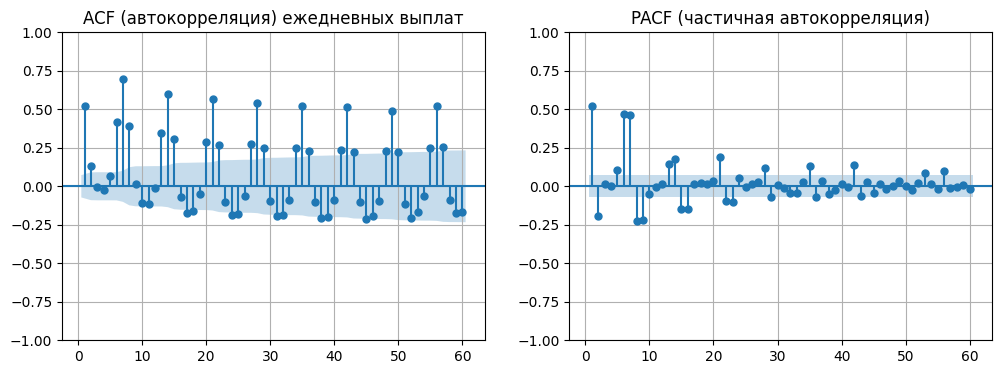

In [984]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(ts_delta, lags=60, ax=plt.gca(), zero=False)
plt.title("ACF (автокорреляция) ежедневных выплат")
plt.grid()

plt.subplot(1,2,2)
plot_pacf(ts_delta, lags=60, ax=plt.gca(), zero=False)
plt.title("PACF (частичная автокорреляция)")
plt.grid()

Статистически значимы лаги каждые 6-8 дней (недельная сезонность). На частичной автокорреляции видно, что лаг в 7 дней будет достаточен, лаги в 4 и более дней не имеют статистической значимости далее. Также лаг в 1 день имеет довольно высокую корреляцию

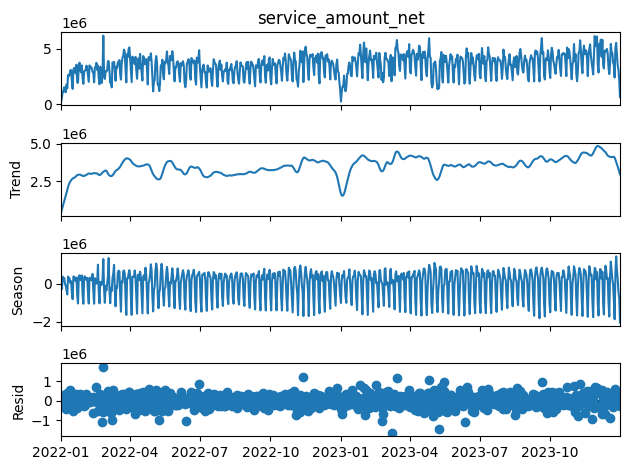

In [981]:
# Проведем STL анализ
stl = STL(ts_delta, period=7)
result = stl.fit()
result.plot()

# Получим очищенный ряд (без тренда и сезонности)
cleaned_day = result.resid

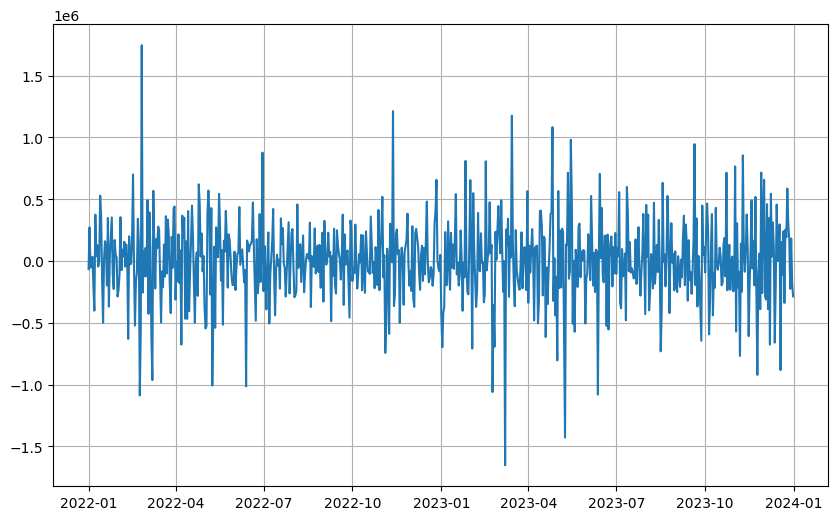

In [982]:
plt.figure(figsize=(10,6))
plt.plot(cleaned_day)
plt.grid()

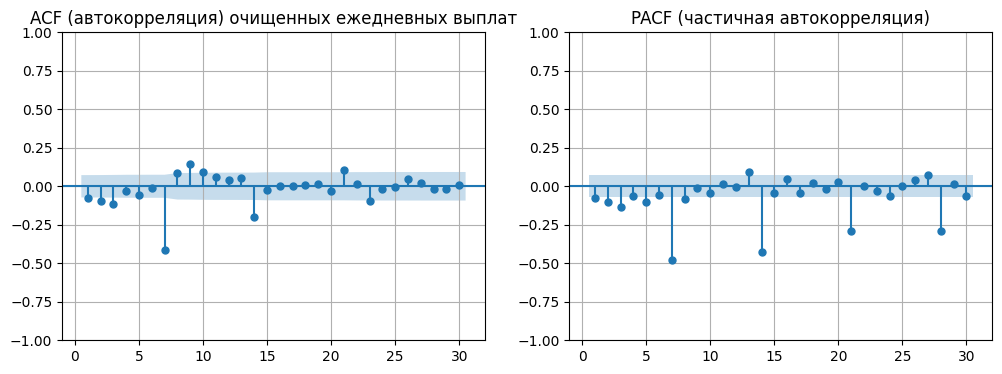

In [985]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(cleaned_day, lags=30, ax=plt.gca(), zero=False)
plt.title("ACF (автокорреляция) очищенных ежедневных выплат")
plt.grid()

plt.subplot(1,2,2)
plot_pacf(cleaned_day, lags=30, ax=plt.gca(), zero=False)
plt.title("PACF (частичная автокорреляция)")
plt.grid()

Автокорреляция на очищенных от тренда и сезонности все еще имеет корреляцию с лагом в 7 дней. Для прогнозирования стоит добавить данный атрибут, также sin и cos по дням и месяцам

### Автокорреляция для ежемесячных данных

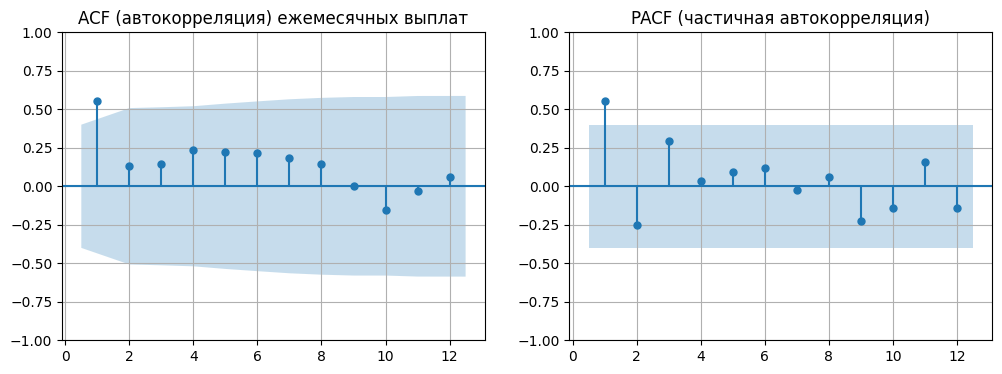

In [986]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(ts_months['service_amount_net'], lags=12, ax=plt.gca(), zero=False)
plt.title("ACF (автокорреляция) ежемесячных выплат")
plt.grid()

plt.subplot(1,2,2)
plot_pacf(ts_months['service_amount_net'], lags=12, ax=plt.gca(), zero=False)
plt.title("PACF (частичная автокорреляция)")
plt.grid()

На месячных данных статистически значим только лаг в 1 месяц.

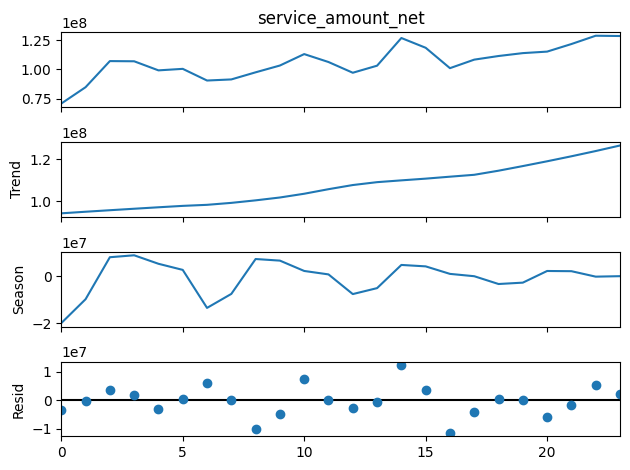

In [689]:
stl = STL(ts_months['service_amount_net'], period=6)
result = stl.fit()
result.plot()

# Получим очищенный ряд (без тренда и сезонности)
cleaned_month = result.resid

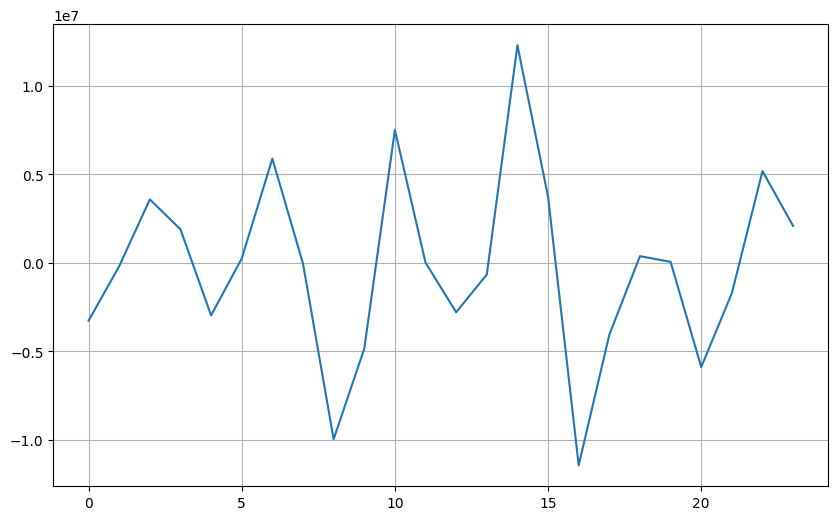

In [690]:
plt.figure(figsize=(10,6))
plt.plot(cleaned_month)
plt.grid()

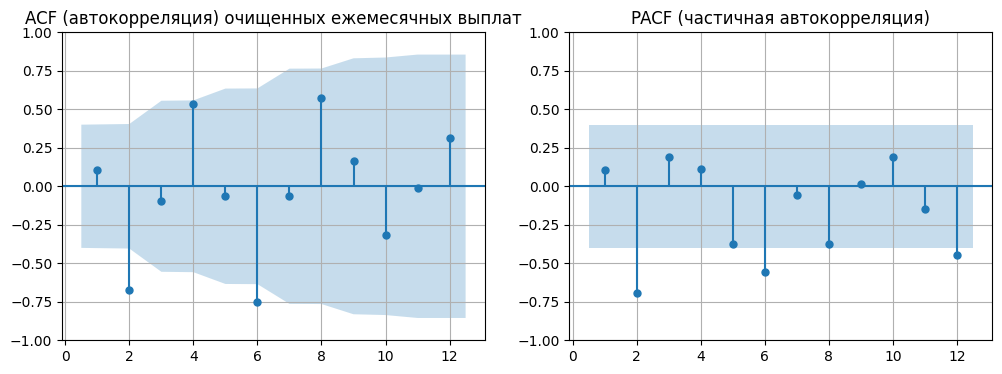

In [691]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(cleaned_month, lags=12, ax=plt.gca(), zero=False)
plt.title("ACF (автокорреляция) очищенных ежемесячных выплат")
plt.grid()

plt.subplot(1,2,2)
plot_pacf(cleaned_month, lags=12, ax=plt.gca(), zero=False)
plt.title("PACF (частичная автокорреляция)")
plt.grid()

# Feature engineering

In [994]:
df_fe = ts_delta.reset_index().copy()
df_fe['service_date'] = pd.to_datetime(df_fe['service_date'])
df_fe.head()

,service_date,service_amount_net
0,2022-01-01,205120.00
1,2022-01-02,623327.09
2,2022-01-03,1133774.60
3,2022-01-04,1118574.22
4,2022-01-05,1527609.83


Добавим лаги по сезонности, которую мы увидели и подтвердили с помощью автокорреляции. Не забудем применить Фурье декомпозицию, чтобы еще лучше подстветить моделям сезонность.

In [995]:
# добавление лага и среднего скользящего окна
df_fe['lag_1'] = df_fe['service_amount_net'].shift(1)
df_fe['roll_7'] = df_fe['service_amount_net'].rolling(7).mean()

# добавление Фурье декомпоизции
df_fe['dayofyear'] = df_fe['service_date'].dt.dayofyear
df_fe['week_sin'] = np.sin(2 * np.pi * df_fe['dayofyear'] / 7)
df_fe['week_cos'] = np.cos(2 * np.pi * df_fe['dayofyear'] / 7)

df_fe['year_sin'] = np.sin(2 * np.pi * df_fe['dayofyear'] / 365)
df_fe['year_cos'] = np.cos(2 * np.pi * df_fe['dayofyear'] / 365)

df_fe['is_weekend'] = df_fe['service_date'].dt.weekday >= 5  # суббота=5, воскресенье=6
df_fe['is_weekend'] = df_fe['is_weekend'].astype(int)  # преобразуем в 0 и 1

df_fe.drop(columns='dayofyear', inplace=True)
df_fe.dropna(inplace=True)
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 724 entries, 6 to 729
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   service_date        724 non-null    datetime64[ns]
 1   service_amount_net  724 non-null    float64       
 2   lag_1               724 non-null    float64       
 3   roll_7              724 non-null    float64       
 4   week_sin            724 non-null    float64       
 5   week_cos            724 non-null    float64       
 6   year_sin            724 non-null    float64       
 7   year_cos            724 non-null    float64       
 8   is_weekend          724 non-null    int64         
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 56.6 KB


In [996]:
ground_truth = df_fe[['service_date', 'service_amount_net']].loc[df_fe['service_date'].dt.year == 2023].groupby(df_fe['service_date'].dt.to_period('M')).sum('service_amount_net').reset_index()
ground_truth['service_date'] = ground_truth['service_date'].dt.strftime('%B %Y')
ground_truth.head()

,service_date,service_amount_net
0,January 2023,9.722742e+07
1,February 2023,1.032548e+08
2,March 2023,1.268799e+08
3,April 2023,1.185448e+08
4,May 2023,1.011387e+08


# Применение ML

Для обучения воспользуем несколькими вариантами ML моделями, а именно Prophet и XGBoost. Данный выбор пал из-за стабильной работой, а также простотой использования и интерпретации.

Также в рамках попытки применения SOTA модели будет рассмотрены резервуарные вычисления, в частности классическая модель ESN.

## Prophet

In [997]:
df_4prophet = df_fe.copy()
df_4prophet.rename(columns={'service_date': 'ds', 'service_amount_net': 'y'}, inplace=True)
df_4prophet.dropna(inplace=True)
df_4prophet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 724 entries, 6 to 729
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          724 non-null    datetime64[ns]
 1   y           724 non-null    float64       
 2   lag_1       724 non-null    float64       
 3   roll_7      724 non-null    float64       
 4   week_sin    724 non-null    float64       
 5   week_cos    724 non-null    float64       
 6   year_sin    724 non-null    float64       
 7   year_cos    724 non-null    float64       
 8   is_weekend  724 non-null    int64         
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 72.7 KB


In [999]:
def monthly_forecast_with_regressors(df, start_date, end_date):
    """
    df: DataFrame с колонками ['ds', 'y', 'lag_1', 'lag_7', 'roll_7', 'week_sin', 'week_cos', 'year_sin', 'year_cos', 'is_weekend']
    start_date: дата начала прогноза (например, '2023-01-01')
    end_date: дата окончания прогноза (например, '2023-12-31')
    """

    df = df.copy()
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds')

    results = []
    current_start = pd.to_datetime(start_date)
    current_end = current_start + pd.offsets.MonthEnd(0)

    while current_start <= pd.to_datetime(end_date):
        # Обучающие данные — всё до начала месяца
        train_df = df[df['ds'] < current_start]

        if len(train_df) < 30:
            current_start += pd.offsets.MonthBegin(1)
            current_end = current_start + pd.offsets.MonthEnd(0)
            continue

        # Prophet с ручными регрессорами
        model = Prophet(
            yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False
        )
        model.add_seasonality(name='yearly', period=365, fourier_order=20)
        model.add_seasonality(name='weekly', period=7, fourier_order=10)

        # Добавляем регрессоры
        model.add_regressor('lag_1')
        model.add_regressor('roll_7')
        model.add_regressor('week_sin')
        model.add_regressor('week_cos')
        model.add_regressor('year_sin')
        model.add_regressor('year_cos')
        model.add_regressor('is_weekend')

        model.fit(train_df)

        # Прогнозируем только следующий месяц
        future = pd.date_range(start=current_start, end=current_end, freq='D')
        future_df = pd.DataFrame({'ds': future})
        future_df['lag_1'] = df.set_index('ds').reindex(future)['lag_1'].values
        future_df['roll_7'] = df.set_index('ds').reindex(future)['roll_7'].values
        future_df['week_sin'] = np.sin(2 * np.pi * future_df['ds'].dt.dayofyear / 7)
        future_df['week_cos'] = np.cos(2 * np.pi * future_df['ds'].dt.dayofyear / 7)
        future_df['year_sin'] = np.sin(2 * np.pi * future_df['ds'].dt.dayofyear / 365)
        future_df['year_cos'] = np.cos(2 * np.pi * future_df['ds'].dt.dayofyear / 365)
        future_df['is_weekend'] = (future_df['ds'].dt.weekday >= 5).astype(int)

        forecast = model.predict(future_df)[['ds', 'yhat']]
        results.append(forecast)

        # Переход к следующему месяцу
        current_start += pd.offsets.MonthBegin(1)
        current_end = current_start + pd.offsets.MonthEnd(0)

    full_forecast = pd.concat(results).reset_index(drop=True)
    full_forecast['month'] = full_forecast['ds'].dt.to_period('M')
    monthly_forecast = full_forecast.groupby('month')['yhat'].sum().reset_index()

    return monthly_forecast

In [1000]:
monthly_forecast = monthly_forecast_with_regressors(
    df_4prophet,
    start_date="2023-01-01",
    end_date="2023-12-31"
)

01:57:08 - cmdstanpy - INFO - Chain [1] start processing
01:57:09 - cmdstanpy - INFO - Chain [1] done processing
01:57:09 - cmdstanpy - INFO - Chain [1] start processing
01:57:09 - cmdstanpy - INFO - Chain [1] done processing
01:57:09 - cmdstanpy - INFO - Chain [1] start processing
01:57:09 - cmdstanpy - INFO - Chain [1] done processing
01:57:09 - cmdstanpy - INFO - Chain [1] start processing
01:57:09 - cmdstanpy - INFO - Chain [1] done processing
01:57:09 - cmdstanpy - INFO - Chain [1] start processing
01:57:09 - cmdstanpy - INFO - Chain [1] done processing
01:57:09 - cmdstanpy - INFO - Chain [1] start processing
01:57:09 - cmdstanpy - INFO - Chain [1] done processing
01:57:09 - cmdstanpy - INFO - Chain [1] start processing
01:57:10 - cmdstanpy - INFO - Chain [1] done processing
01:57:10 - cmdstanpy - INFO - Chain [1] start processing
01:57:10 - cmdstanpy - INFO - Chain [1] done processing
01:57:10 - cmdstanpy - INFO - Chain [1] start processing
01:57:10 - cmdstanpy - INFO - Chain [1]

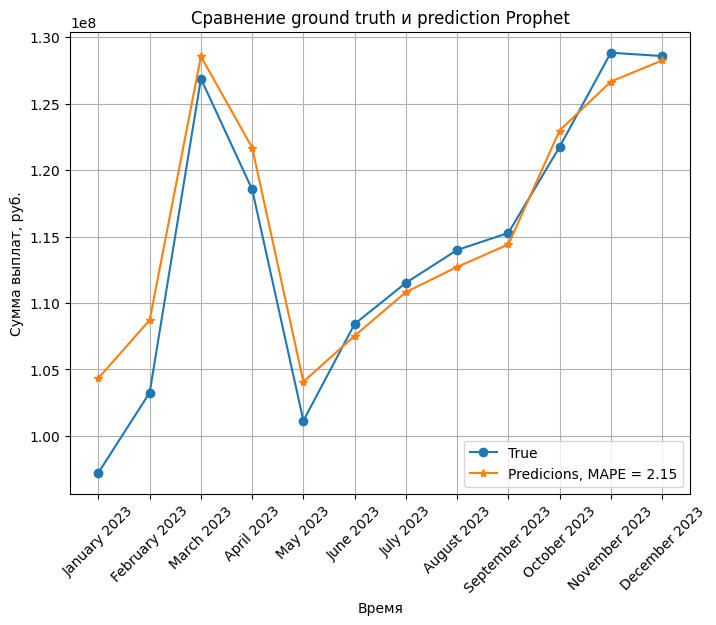

In [1001]:
plt.figure(figsize=(8,6))
plt.plot(ground_truth['service_date'], ground_truth['service_amount_net'], label='True', marker='o')
plt.plot(monthly_forecast['yhat'], label=f"Predicions, MAPE = {round(mean_absolute_percentage_error(ground_truth['service_amount_net'], monthly_forecast['yhat'])*100,2)}",
         marker='*')
plt.title('Сравнение ground truth и prediction Prophet')
plt.xlabel('Время')
plt.xticks(rotation=45)
plt.ylabel('Сумма выплат, руб.')
plt.legend()
plt.grid()

In [1012]:
print(f"Средняя абсолютная ошибка по месяцам: {mean_absolute_error(ground_truth['service_amount_net'], monthly_forecast['yhat']):2e} руб.")

Средняя абсолютная ошибка по месяцам: 2.317647e+06 руб.


## XGBoost

In [1002]:
def xgboost_hyperparameter_search(X, y):
    """
    Подбор гиперпараметров для XGBRegressor с помощью GridSearchCV
    """
    model = XGBRegressor(seed=23)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 8],
        'learning_rate': [0.01, 0.1, 0.25],
    }
    scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
    grid_search.fit(X, y)
    return grid_search.best_params_

X_train = df_fe[['lag_1', 'roll_7', 'week_sin', 'week_cos', 'year_sin', 'year_cos', 'is_weekend']]
y_train = df_fe['service_amount_net']

best_xgb_params = xgboost_hyperparameter_search(X_train, y_train)
print("Лучшие параметры XGBoost:", best_xgb_params)


Лучшие параметры XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [1003]:
def monthly_forecast_xgboost(df, start_date, end_date, params=None):
    """
    df: DataFrame с колонками ['ds', 'y', 'lag_1', 'lag_7', 'week_sin', 'week_cos', 'year_sin', 'year_cos', 'is_weekend']
    start_date: дата начала прогноза
    end_date: дата окончания прогноза
    params: если не None, передаются параметры для модели
    """

    df = df.copy()
    df['service_date'] = pd.to_datetime(df['service_date'])
    df = df.sort_values('service_date')

    results = []
    current_start = pd.to_datetime(start_date)
    current_end = current_start + pd.offsets.MonthEnd(0)

    features = ['lag_1', 'roll_7', 'week_sin', 'week_cos', 'year_sin', 'year_cos', 'is_weekend']

    while current_start <= pd.to_datetime(end_date):
        # обучающая выборка: всё до текущего месяца
        train_df = df[df['service_date'] < current_start]
        test_df = df[(df['service_date'] >= current_start) & (df['service_date'] <= current_end)]

        if len(train_df) < 30 or test_df.empty:
            current_start += pd.offsets.MonthBegin(1)
            current_end = current_start + pd.offsets.MonthEnd(0)
            continue

        X_train, y_train = train_df[features], train_df['service_amount_net']
        X_test = test_df[features]

        if params is None:
            model = XGBRegressor(n_estimators=20, learning_rate=0.2, seed=23)
        else:
            model = XGBRegressor(**params, seed=23)

        model.fit(X_train, y_train)
        yhat = model.predict(X_test)

        month_forecast = pd.DataFrame({
            'service_date': test_df['service_date'].values,
            'service_amount_net': yhat
        })
        results.append(month_forecast)

        # сдвиг окна
        current_start += pd.offsets.MonthBegin(1)
        current_end = current_start + pd.offsets.MonthEnd(0)

    # объединяем
    full_forecast = pd.concat(results).reset_index(drop=True)
    full_forecast['month'] = full_forecast['service_date'].dt.to_period('M')
    monthly_forecast = full_forecast.groupby('month')['service_amount_net'].sum().reset_index()

    return monthly_forecast

In [1004]:
forecast_xgb = monthly_forecast_xgboost(df_fe, start_date='2023-01-01', end_date='2023-12-31', params=best_xgb_params)

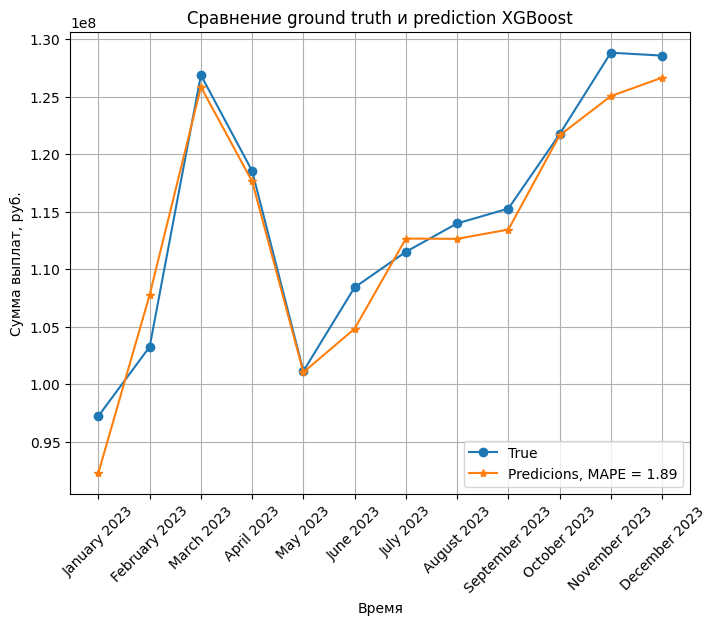

In [1005]:
plt.figure(figsize=(8,6))
plt.plot(ground_truth['service_date'], ground_truth['service_amount_net'], label='True', marker='o')
plt.plot(forecast_xgb['service_amount_net'], label=f"Predicions, MAPE = {round(mean_absolute_percentage_error(ground_truth['service_amount_net'], forecast_xgb['service_amount_net'])*100,2)}",
         marker='*')
plt.title('Сравнение ground truth и prediction XGBoost')
plt.xlabel('Время')
plt.xticks(rotation=45)
plt.ylabel('Сумма выплат, руб.')
plt.legend()
plt.grid()

In [1011]:
print(f"Средняя абсолютная ошибка по месяцам: {mean_absolute_error(ground_truth['service_amount_net'], forecast_xgb['service_amount_net']):2e} руб.")

Средняя абсолютная ошибка по месяцам: 2.098749e+06 руб.


## ESN

# Запись результата